# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). This workspace is to build my project, and to explore a smaller subset with Spark before deploying my cluster on AWS. 

In [1]:
# importing neccesary libraries
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import max as fmax, isnull, avg, udf, split, sum as fsum, countDistinct, col, desc
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
import datetime

import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# creating a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. I will load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

Let's load our data and take a look a quick look to understand how it's organized.

In [3]:
# loading data
event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(event_data)
df.head()
df.toPandas().to_csv('sparkify_data.csv')

In [4]:
# data schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# total number of records before cleaning
df.count()

286500

To begin cleaning let's look for any missing data that wasn't entered and would be a blank entry.

In [6]:
# checking for missing data
cols = df.columns

for col in cols:
    print(col, df.filter(df[col] == '').count())

artist 0
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 0
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 0
status 0
ts 0
userAgent 0
userId 8346


The 'userId' column has 8346 invalid enteries so let's remove these because we want to make conclusions about users in the future.

In [7]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910559|
|    min|                  |
|    max|                99|
+-------+------------------+



In [8]:
df = df.filter(df['userId'] != '')

In [9]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            278154|
|   mean| 59682.02278593872|
| stddev|109091.94999910559|
|    min|                10|
|    max|                99|
+-------+------------------+



We succesfully removed the invalid enteries. 

I'm skeptical that is the furthest extent to which we need to clean this data so lets look for other irregularities.

Looking back our schema I want to investigate the columns where invalid enteries could be important to catch. Specifically, auth, itemInSession, length, level, location, method, page, registration, sessionId, status, ts, userAgent, userId.

These columns either have values I want to know more about or have a possibility to affect our results. Let's take a look.


In [10]:
cols = df.columns

for col in cols:
    print(col, df.filter(df[col] == 'null').count())

artist 0
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 0
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 0
status 0
ts 0
userAgent 0
userId 0


We should investigate further it is unlikely there are no null values in this dataset.

In [11]:
cols = df.columns

for col in cols:
    print(col, df.filter(isnull(df[col])).count())

artist 50046
auth 0
firstName 0
gender 0
itemInSession 0
lastName 0
length 50046
level 0
location 0
method 0
page 0
registration 0
sessionId 0
song 50046
status 0
ts 0
userAgent 0
userId 0


Well that's interesting, it appears the null value is not saved as a string. This is something to be wary of. 

The null values will not affect our results because they are not important to define cutomer churn. We will leave them in place and I will discuss customer churn in the coming sections.

## Exploratory Data Analysis


### Variable Exploration

Let's creat a table to use Spark SQL to investigate our variables.

In [12]:
df.createOrReplaceTempView('user_table')

Here I will investigate variables which I find of interest and might prove to be useful in predictions or simply to understand their meaning. The variables are:
- auth
- itemInSession
- level
- location
- method
- page
- registration
- sessionId
- status
- ts
- userAgent
- userId
- gender

- <b>auth</b> takes on the following values: Cancelled, Logged In
> There are 225 active users in this dataset and 52 users who have cancelled. This will not be a useful variable. We can find this information in other variables.

In [13]:
spark.sql('''
          SELECT auth, COUNT(DISTINCT userId) AS count
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show()

+---------+-----+
|     auth|count|
+---------+-----+
|Logged In|  225|
|Cancelled|   52|
+---------+-----+



In [14]:
spark.sql('''
          SELECT COUNT(DISTINCT userId) AS user_count
          FROM user_table
          '''
          ).show()

+----------+
|user_count|
+----------+
|       225|
+----------+



- <b>itemInSession</b>: takes on incremental values for each action during a session on Sparkify
> We would have assumed as itemInSession incremented the counts would decrease but this isn't the case. It looks like this variable won't be very useful due to this unpredictable nature for the general population. However, this variable might be useful for predictions on individual users.

In [15]:
spark.sql('''
          SELECT itemInSession, COUNT(*) AS count
          FROM user_table
          GROUP BY 1
          ORDER BY 1 ASC
          LIMIT 5
          '''
          ).show()

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            0| 2689|
|            1| 2818|
|            2| 2941|
|            3| 2917|
|            4| 2887|
+-------------+-----+



In [16]:
spark.sql('''
          SELECT *
          FROM user_table
          WHERE userId = 10
          LIMIT 5
          '''
          ).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|  location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|            Sea Wolf|Logged In|   Brycen|     M|            0| Bradley|265.53424| paid|Laurel, MS|   PUT|NextSong|1538159495000|        9|       Ses Monuments|   200|1538965220000|"Mozilla/5.0 (Mac...|    10|
|George Baker Sele...|Logged In|   Brycen|     M|            1| Bradley| 200.4371| paid|Laurel, MS|   PUT|NextSong|1538159495000|        9|         Morning Sky|

- <b>level</b> takes on the following values: free, paid
> There have been a max of 195 users using the free service and 165 users using the paid service. This may be a useful variable.

In [17]:
spark.sql('''
          SELECT level, COUNT(DISTINCT userId) AS count
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  165|
+-----+-----+



- <b>location</b> has the following format: city, state(2 digit abbreviation)
> The variables I created, city and state are useful

In [18]:
spark.sql('''
          SELECT location, COUNT(DISTINCT userId)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show(100, truncate = False)

+---------------------------------------------+----------------------+
|location                                     |count(DISTINCT userId)|
+---------------------------------------------+----------------------+
|Los Angeles-Long Beach-Anaheim, CA           |16                    |
|New York-Newark-Jersey City, NY-NJ-PA        |15                    |
|Dallas-Fort Worth-Arlington, TX              |7                     |
|Phoenix-Mesa-Scottsdale, AZ                  |7                     |
|Chicago-Naperville-Elgin, IL-IN-WI           |6                     |
|Charlotte-Concord-Gastonia, NC-SC            |6                     |
|St. Louis, MO-IL                             |6                     |
|Boston-Cambridge-Newton, MA-NH               |5                     |
|Philadelphia-Camden-Wilmington, PA-NJ-DE-MD  |5                     |
|Miami-Fort Lauderdale-West Palm Beach, FL    |5                     |
|Atlanta-Sandy Springs-Roswell, GA            |4                     |
|Houst

In [19]:
# new column city
df = df.withColumn('city', split(df['location'], ',').getItem(0))
df = df.withColumn('city', split(df['city'], '-').getItem(0))
# new column state
df = df.withColumn('state', split(df['location'], ',').getItem(1))
df = df.withColumn('state', split(df['state'], '-').getItem(0))
# creating an updated view
df.createOrReplaceTempView('user_table')

In [20]:
spark.sql('''
          SELECT city, COUNT(DISTINCT userId)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show(100, truncate = False)

+---------------------------+----------------------+
|city                       |count(DISTINCT userId)|
+---------------------------+----------------------+
|Los Angeles                |16                    |
|New York                   |15                    |
|Dallas                     |7                     |
|Phoenix                    |7                     |
|Chicago                    |6                     |
|Charlotte                  |6                     |
|St. Louis                  |6                     |
|Miami                      |5                     |
|Philadelphia               |5                     |
|Boston                     |5                     |
|Atlanta                    |4                     |
|Houston                    |4                     |
|Washington                 |4                     |
|Las Vegas                  |3                     |
|San Diego                  |3                     |
|New Haven                  |3                

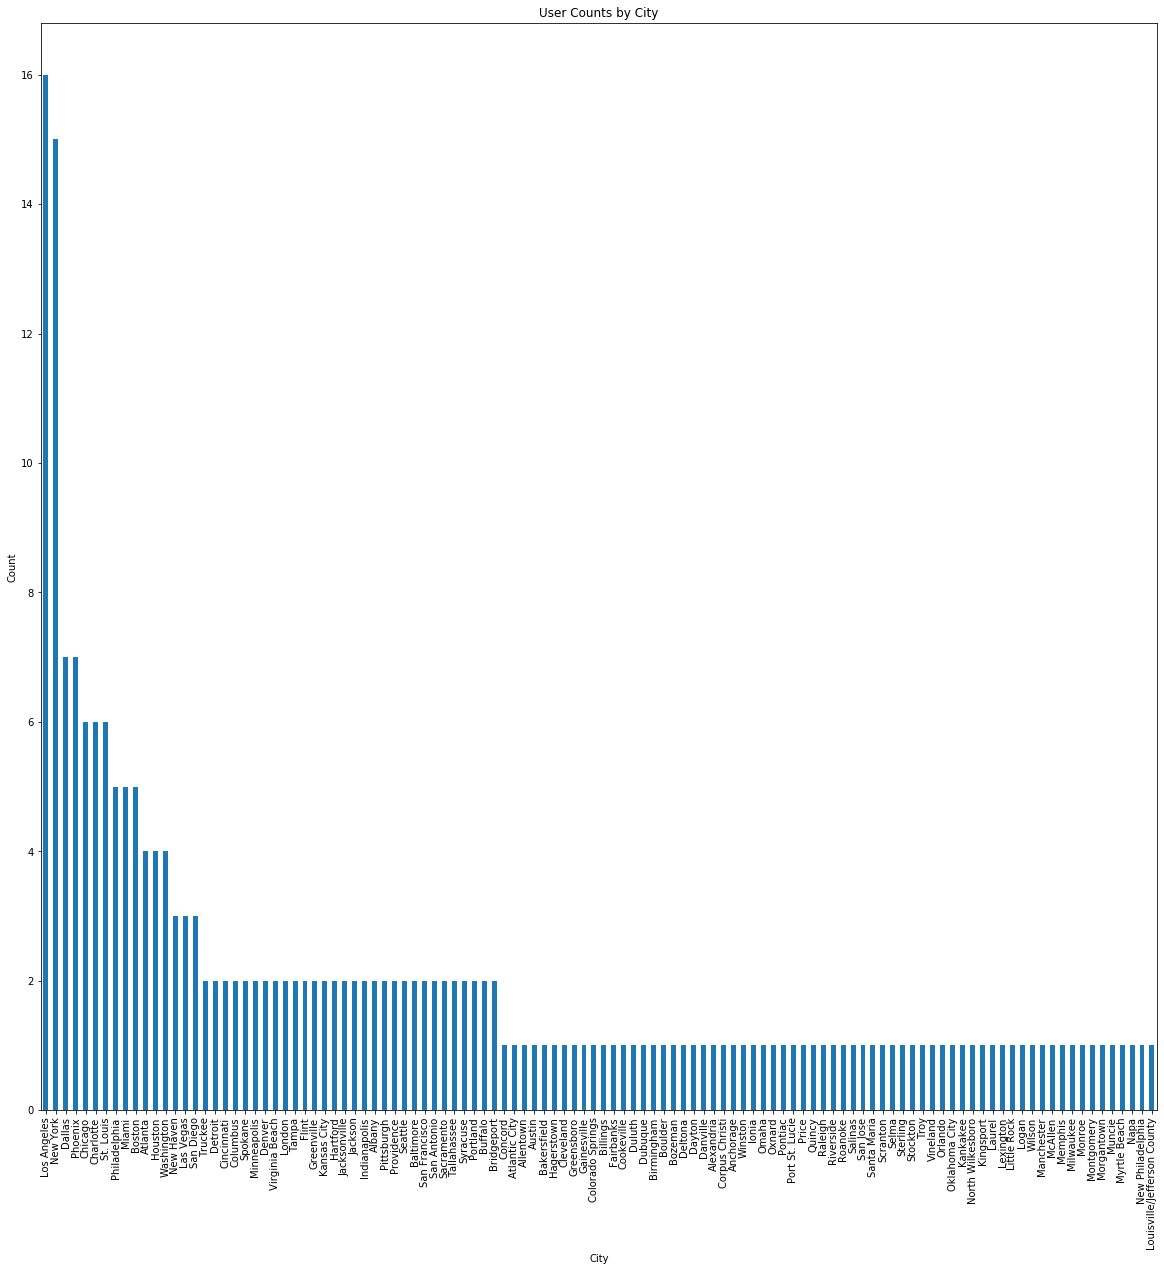

In [21]:
city_count = spark.sql('''
                       SELECT city, COUNT(DISTINCT userId) AS count
                       FROM user_table
                       GROUP BY 1
                       ORDER BY 2 DESC
                       '''
                       ).toPandas()

plt.figure(figsize = (20,20))
city_count.groupby('city')['count'].sum().sort_values(ascending=False).plot.bar()
plt.xlabel('City')
plt.ylabel('Count')
plt.title('User Counts by City');

In [22]:
spark.sql('''
          SELECT state, COUNT(DISTINCT userId)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show(52)

+-----+----------------------+
|state|count(DISTINCT userId)|
+-----+----------------------+
|   CA|                    33|
|   NY|                    20|
|   TX|                    16|
|   FL|                    14|
|   NC|                    12|
|   IL|                    10|
|   PA|                     9|
|   MO|                     8|
|   CT|                     7|
|   AZ|                     7|
|   GA|                     6|
|   MA|                     5|
|   OH|                     5|
|   MI|                     5|
|   KY|                     4|
|   VA|                     4|
|   CO|                     4|
|   WA|                     4|
|   DC|                     4|
|   AL|                     4|
|   MD|                     3|
|   IN|                     3|
|   NV|                     3|
|   OR|                     3|
|   MS|                     3|
|   SC|                     3|
|   TN|                     3|
|   MN|                     3|
|   NH|                     2|
|   AK| 

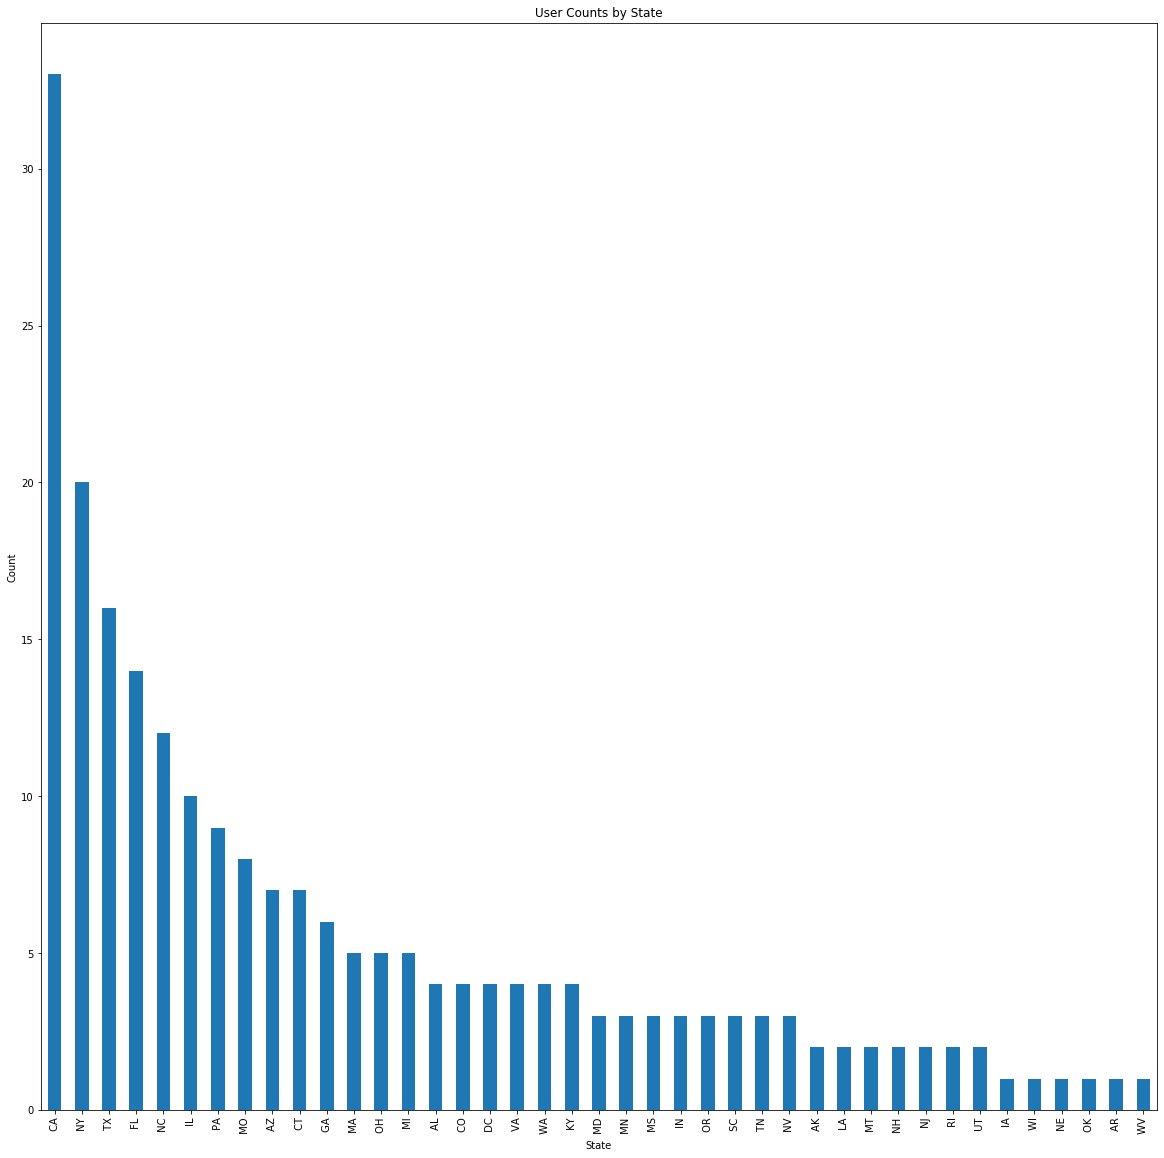

In [23]:
state_count = spark.sql('''
                        SELECT state, COUNT(DISTINCT userId) AS count
                        FROM user_table
                        GROUP BY 1
                        ORDER BY 2 DESC
                        '''
                        ).toPandas()

plt.figure(figsize = (20,20))
state_count.groupby('state')['count'].sum().sort_values(ascending=False).plot.bar()
plt.xlabel('State')
plt.ylabel('Count')
plt.title('User Counts by State');

- <b>method</b> has the following values: PUT, GET
> It is correlated to all the null values from artist, song, and length we discovered while cleaning. Not quite sure what this variable means so it wont be useful. 

In [24]:
spark.sql('''
          SELECT DISTINCT method
          FROM user_table
          '''
          ).show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [25]:
spark.sql('''
          SELECT *
          FROM user_table
          WHERE method = 'GET'
          LIMIT 5
          '''
          ).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|       page| registration|sessionId|song|status|           ts|           userAgent|userId|     city|state|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+---------+-----+
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|   Boston|   MA|
|  null|Logged In|    Alexi|     F|            4|  Warren|  null| paid|Spokane-Spokane V...|   GET|  Downgrade|1532482662000|       53|null|   200|1538354749000|Mozilla/5.0 (Wi

- <b>page</b> is the most insightful variable of the current users behaviour with the following values:
>Cancel<br>
>Submit Downgrade<br>
>Thumbs Down<br>
>Home<br>
>Downgrade<br>
>Roll Advert<br>
>Logout<br>
>Save Settings<br>
>Cancellation Confirmation<br>
>About<br>
>Settings<br>
>Add to Playlist<br>
>Add Friend<br>
>NextSong<br>
>Thumbs Up<br>
>Help<br>
>Upgrade<br>
>Error<br>
>Submit Upgrade<br>
<br>
> This variable will be useful<br>



In [26]:
spark.sql('''
          SELECT page, COUNT(userId)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 DESC
          '''
          ).show()

+--------------------+-------------+
|                page|count(userId)|
+--------------------+-------------+
|            NextSong|       228108|
|           Thumbs Up|        12551|
|                Home|        10082|
|     Add to Playlist|         6526|
|          Add Friend|         4277|
|         Roll Advert|         3933|
|              Logout|         3226|
|         Thumbs Down|         2546|
|           Downgrade|         2055|
|            Settings|         1514|
|                Help|         1454|
|             Upgrade|          499|
|               About|          495|
|       Save Settings|          310|
|               Error|          252|
|      Submit Upgrade|          159|
|    Submit Downgrade|           63|
|              Cancel|           52|
|Cancellation Conf...|           52|
+--------------------+-------------+



- <b>registration</b>: formatted in a 13 digit unixtime format which appears to be the time of registration
> This variable will be useful as the registrationTimestamp variable I created.

In [27]:
dateTime = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn('registrationTimestamp', dateTime('registration'))
df.createOrReplaceTempView('user_table')

spark.sql('''
          SELECT DISTINCT registration, registrationTimestamp
          FROM user_table
          ORDER BY 1 ASC
          LIMIT 5
          '''
          ).show()

+-------------+---------------------+
| registration|registrationTimestamp|
+-------------+---------------------+
|1521380675000|  2018-03-18 09:44:35|
|1526739206000|  2018-05-19 10:13:26|
|1526838391000|  2018-05-20 13:46:31|
|1528403713000|  2018-06-07 16:35:13|
|1528560242000|  2018-06-09 12:04:02|
+-------------+---------------------+



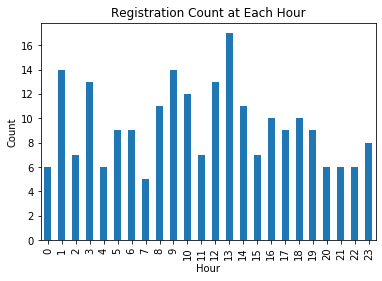

In [28]:
hour = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).hour, IntegerType())
df = df.withColumn('registrationHour', hour('registration'))
df.createOrReplaceTempView('user_table')

reg_hour_count = spark.sql('''
                           SELECT registrationHour, COUNT(DISTINCT userId) AS count
                           FROM user_table
                           GROUP BY 1
                           ORDER BY 1 ASC
                           '''
                           ).toPandas()

reg_hour_count.groupby('registrationHour')['count'].sum().plot.bar()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Registration Count at Each Hour');

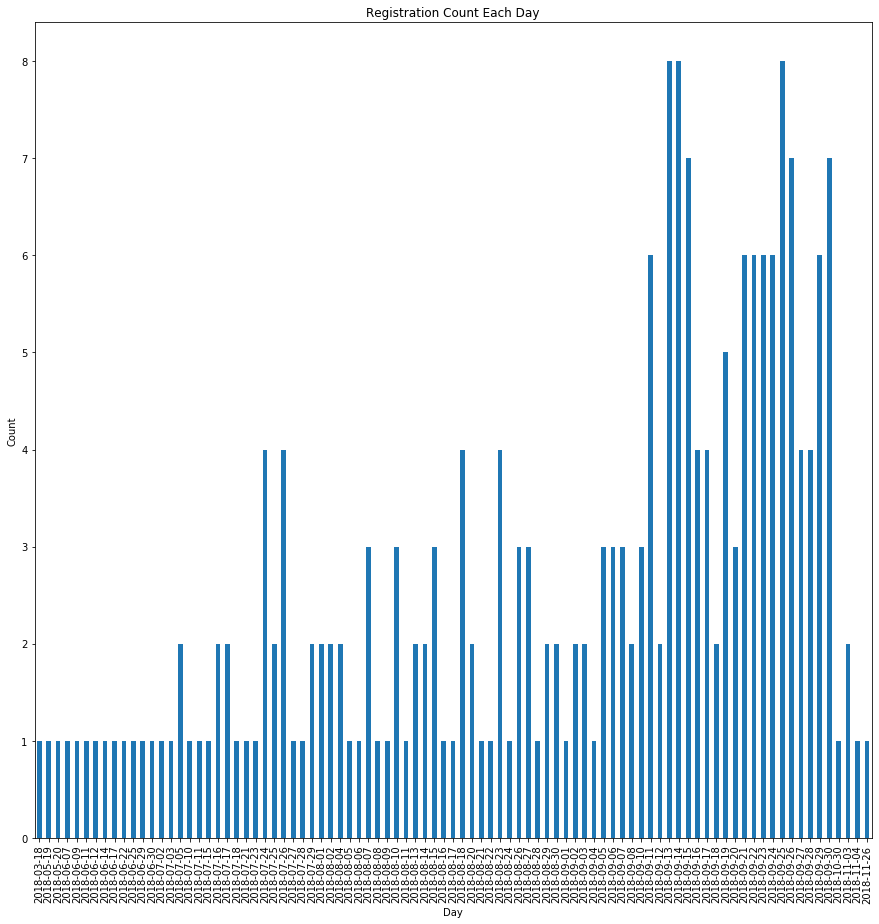

In [29]:
date = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%d'))
df = df.withColumn('registrationDay', date('registration'))
df.createOrReplaceTempView('user_table')

reg_day_count = spark.sql('''
                           SELECT registrationDay, COUNT(DISTINCT userId) AS count
                           FROM user_table
                           GROUP BY 1
                           ORDER BY 1 ASC
                           '''
                           ).toPandas()

plt.figure(figsize=(15,15))
reg_day_count.groupby('registrationDay')['count'].sum().plot.bar()
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Registration Count Each Day');

- <b>sessionId</b>: doesn't seem to be unique to any user or increment.
> This variable will not be useful.

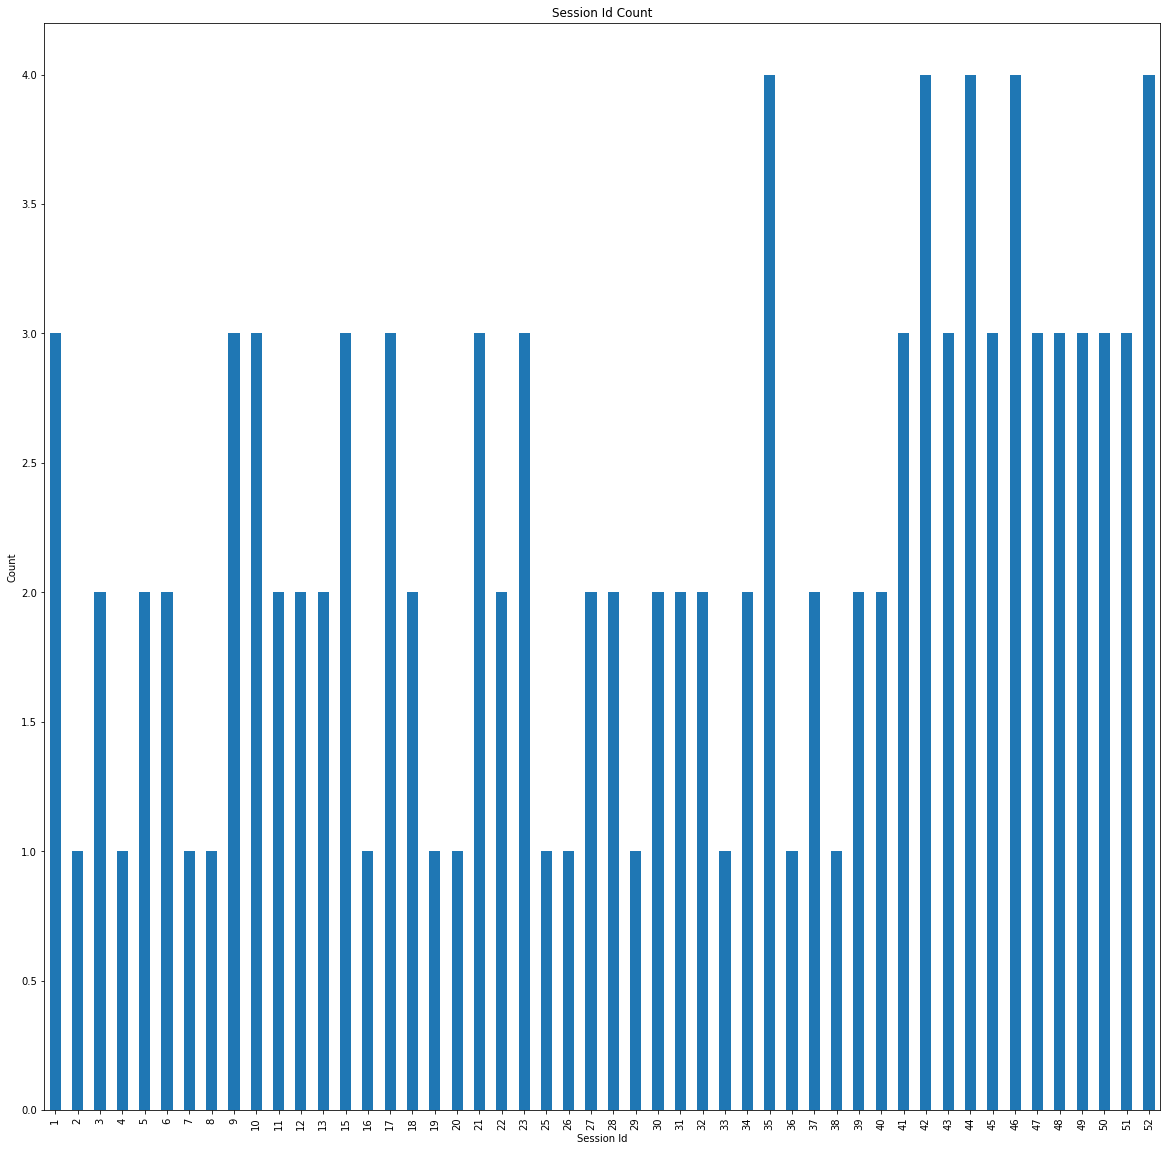

In [30]:
sessionId_count = spark.sql('''
                            SELECT sessionId, COUNT(DISTINCT userId) AS count
                            FROM user_table
                            GROUP BY 1
                            ORDER BY 1 ASC
                            LIMIT 50
                            '''
                            ).toPandas()

sessionId_count.sessionId.astype('int64')
plt.figure(figsize=(20,20))
sessionId_count.groupby('sessionId')['count'].sum().plot.bar()
plt.xlabel('Session Id')
plt.ylabel('Count')
plt.title('Session Id Count');

In [31]:
spark.sql('''
          SELECT page, sessionId
          FROM user_table
          WHERE page = 'Home'
          LIMIT 20
          '''
          ).show()

+----+---------+
|page|sessionId|
+----+---------+
|Home|        8|
|Home|        8|
|Home|      240|
|Home|      240|
|Home|      100|
|Home|      187|
|Home|      241|
|Home|      100|
|Home|      187|
|Home|      187|
|Home|      187|
|Home|      187|
|Home|      222|
|Home|      100|
|Home|      141|
|Home|      255|
|Home|      141|
|Home|      267|
|Home|       86|
|Home|      266|
+----+---------+



<b>status</b> takes on the following values: 200, 307, 400
> 200 -> Next Song<br>
> 307 -> Thumbs Up, Thumbs Down, Logout<br>
> 400 -> error<br>
<br>
> Other variables show us this same information. This variable is not useful.

In [32]:
spark.sql('''
          SELECT DISTINCT status
          FROM user_table
          ORDER BY 1 ASC
          '''
          ).show()

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [33]:
spark.sql('''
          SELECT *
          FROM user_table
          WHERE status = 200
          '''
          ).show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+---------------------+----------------+---------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|       city|state|registrationTimestamp|registrationHour|registrationDay|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----------+-----+---------------------+----------------+---------------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|153817336200

In [34]:
spark.sql('''
          SELECT *
          FROM user_table
          WHERE status = 307
          '''
          ).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+-----------+-----+---------------------+----------------+---------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|       page| registration|sessionId|song|status|           ts|           userAgent|userId|       city|state|registrationTimestamp|registrationHour|registrationDay|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----------+-------------+---------+----+------+-------------+--------------------+------+-----------+-----+---------------------+----------------+---------------+
|  null|Logged In|    Micah|     M|           86|    Long|  null| free|Boston-Cambridge-...|   PUT|  Thumbs Up|1538331630000|        8|null|   307|1538353376000|"Mozilla/5.0 (Win...|     9|     Boston|   MA|  20

In [35]:
spark.sql('''
          SELECT *
          FROM user_table
          WHERE status = 404
          '''
          ).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+-----+---------------------+----------------+---------------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method| page| registration|sessionId|song|status|           ts|           userAgent|userId|                city|state|registrationTimestamp|registrationHour|registrationDay|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+-----+-------------+---------+----+------+-------------+--------------------+------+--------------------+-----+---------------------+----------------+---------------+
|  null|Logged In|     Kael|     M|           48|   Baker|  null| paid|Kingsport-Bristol...|   GET|Error|1533102330000|      249|null|   404|1538393848000|"Mozilla/5.0 (Mac...|   131|           Kingspor

<b>ts</b> is in 13 digit unixtime which shows the time that the page was visited.
> The variable timstamp I created will be useful.

In [36]:
dateTime = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
df = df.withColumn('timestamp', dateTime('ts'))
df.createOrReplaceTempView('user_table')

In [37]:
spark.sql('''
          SELECT ts, timestamp
          FROM user_table
          ORDER BY 1 ASC
          LIMIT 5
          '''
          ).show()

+-------------+-------------------+
|           ts|          timestamp|
+-------------+-------------------+
|1538352117000|2018-09-30 20:01:57|
|1538352180000|2018-09-30 20:03:00|
|1538352394000|2018-09-30 20:06:34|
|1538352416000|2018-09-30 20:06:56|
|1538352676000|2018-09-30 20:11:16|
+-------------+-------------------+



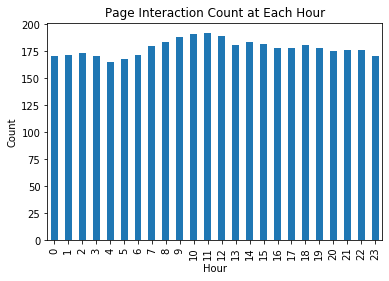

In [38]:
hour = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).hour, IntegerType())
df = df.withColumn('timestampHour', hour('ts'))
df.createOrReplaceTempView('user_table')

ts_hour_count = spark.sql('''
                          SELECT timestampHour, COUNT(DISTINCT userId) AS count
                          FROM user_table
                          GROUP BY 1
                          ORDER BY 1 ASC
                          '''
                          ).toPandas()

ts_hour_count.groupby('timestampHour')['count'].sum().plot.bar()
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Page Interaction Count at Each Hour');

In [39]:
spark.sql('''
          SELECT DISTINCT page, AVG(timestampHour)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 ASC
          '''
          ).show()

+--------------------+------------------+
|                page|avg(timestampHour)|
+--------------------+------------------+
|    Submit Downgrade|10.301587301587302|
|               Error|11.031746031746032|
|      Submit Upgrade|11.176100628930818|
|               About|11.296969696969697|
|            Settings|11.479524438573316|
|             Upgrade|11.557114228456914|
|                Home|11.569728228526087|
|       Save Settings|11.619354838709677|
|              Logout|11.646311221326721|
|           Thumbs Up|11.710301967970679|
|            NextSong|11.732745015518965|
|           Downgrade| 11.74403892944039|
|                Help|11.752407152682256|
|     Add to Playlist|   11.784554091327|
|              Cancel|11.865384615384615|
|          Add Friend|11.880991349076455|
|Cancellation Conf...|11.884615384615385|
|         Roll Advert|11.966692092550216|
|         Thumbs Down|12.055380989787903|
+--------------------+------------------+



<b>userAgent</b> shows how the user accessed sparkify, the possible values follow.
> This variable will not be useful because a user could have accessed sparkify through multiple platforms.

In [40]:
userAgent_count = spark.sql('''
                            SELECT userAgent, COUNT(DISTINCT userId) AS count
                            FROM user_table
                            GROUP BY 1
                            ORDER BY 1 ASC
                            '''
                            ).toPandas()

In [41]:
userAgent_count

,userAgent,count
0,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",1
1,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",2
2,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",1
3,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",1
4,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_5...",2
5,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",1
6,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...",1
7,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",2
8,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",1
9,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2...",1


<b>userId</b> is between 2 and 5 digits. This is integral to the dataset to isolate instances and events.
> This variable is useful

In [42]:
spark.sql('''
          SELECT DISTINCT userId
          FROM user_table
          ORDER BY 1 ASC
          LIMIT 5
          '''
          ).show()

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+



<b>gender</b> can only take one of two values: M, F. There are 104 females and 121 males.
> This variable is useful

In [43]:
spark.sql('''
          SELECT gender, COUNT(DISTINCT userId)
          FROM user_table
          GROUP BY 1
          ORDER BY 2 ASC
          '''
          ).show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|     F|                   104|
|     M|                   121|
+------+----------------------+



In [44]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- registrationTimestamp: string (nullable = true)
 |-- registrationHour: integer (nullable = true)
 |-- registrationDay: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timestampHour: integer (nullable = tru

Using the results of our exploratory analysis I will condense the dataset to only the useful variables. The variables being:
- userId
- gender
- registrationTimestamp
- level
- city
- state
- itemInSession
- page
- timestamp
- platfrom

In [45]:
df = spark.sql('''SELECT userId, 
                    gender,
                    registrationTimestamp,
                    level, 
                    city, 
                    state, 
                    itemInSession,
                    page, 
                    timestamp,
                    artist,
                    song,
                    length
                  FROM user_table
                  ORDER BY userId, timestamp
                  '''
                  )

df.createOrReplaceTempView('user_table')

### Defining Churn

Now that we've done some preliminary analysis, let's create a column `Churn` to use as the label for our model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, we can also look into the `Downgrade` events.

[Customer Churn](https://www.investopedia.com/terms/c/churnrate.asp) is a metric which measures the rate at which customers stop doing business with an entity. In our case when customers move from Sparkify's paid service level to free.

We can encode two variables to try and understand churn. One variable can encode when the page `Cancellation Confrimation` is visited. As well, we can also encode a variable for when the `Downgrade` page is visited. Looking back at our distinct values for the column 'page' we can assume the process of customer churn goes from `Downgrade`-> `Submit Downgrade`-> `Cancel`->`Cancellation Confirmation`. If we can identify customers who visit the downgrade and don't proceed to submit the downgrade immeadiately we can decrease our churn rate and retain customers. We can also help identify what might cause customers to `Cancel`.

Let's create a `possibleChurn` column that marks a `Downgrade` page visit.


In [49]:
df.filter(df.page == 'Downgrade').show(1)

+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+
|userId|gender|registrationTimestamp|level|  city|state|itemInSession|     page|          timestamp|artist|song|length|
+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+
|    10|     M|  2018-09-28 14:31:35| paid|Laurel|   MS|           17|Downgrade|2018-10-18 00:42:33|  null|null|  null|
+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+
only showing top 1 row



In [50]:
possChurn = udf(lambda x: 1 if x == 'Downgrade' else 0, IntegerType())
df = df.withColumn('possibleChurn', possChurn('page'))
df.filter(df.page == 'Downgrade').show(1)

+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+-------------+
|userId|gender|registrationTimestamp|level|  city|state|itemInSession|     page|          timestamp|artist|song|length|possibleChurn|
+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+-------------+
|    10|     M|  2018-09-28 14:31:35| paid|Laurel|   MS|           17|Downgrade|2018-10-18 00:42:33|  null|null|  null|            1|
+------+------+---------------------+-----+------+-----+-------------+---------+-------------------+------+----+------+-------------+
only showing top 1 row



We successfully encoded a variable for possible customer churn and created a new column `possibleChurn` when the `Downgrade` page is visited. Let's do this again for when the `Cancellation Confirmation` page is vistited.

In [52]:
df.filter(df.page == 'Cancellation Confirmation').show(1)

+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+
|userId|gender|registrationTimestamp|level| city|state|itemInSession|                page|          timestamp|artist|song|length|possibleChurn|
+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+
|100001|     F|  2018-08-18 17:24:26| free|Miami|   FL|           23|Cancellation Conf...|2018-10-02 12:36:45|  null|null|  null|            0|
+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+
only showing top 1 row



In [54]:
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn', churn('page'))
df.filter(df.page == 'Cancellation Confirmation').show(1)

+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+-----+
|userId|gender|registrationTimestamp|level| city|state|itemInSession|                page|          timestamp|artist|song|length|possibleChurn|churn|
+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+-----+
|100001|     F|  2018-08-18 17:24:26| free|Miami|   FL|           23|Cancellation Conf...|2018-10-02 12:36:45|  null|null|  null|            0|    1|
+------+------+---------------------+-----+-----+-----+-------------+--------------------+-------------------+------+----+------+-------------+-----+
only showing top 1 row



Alright we successfully encoded a variable for customer churn and created a new column `churn` when the `Cancellation Confirmation` is visited. Let's explore out data and try and gain insights from our data and use our new variables `possibleChurn` and `churn`.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [55]:
df.createOrReplaceTempView('user_table')

In [56]:
spark.sql('''SELECT *
             FROM user_table
             ORDER BY userId, timestamp
             '''
             ).show(5)

+------+------+---------------------+-----+------+-----+-------------+--------+-------------------+--------------------+--------------------+---------+-------------+-----+
|userId|gender|registrationTimestamp|level|  city|state|itemInSession|    page|          timestamp|              artist|                song|   length|possibleChurn|churn|
+------+------+---------------------+-----+------+-----+-------------+--------+-------------------+--------------------+--------------------+---------+-------------+-----+
|    10|     M|  2018-09-28 14:31:35| paid|Laurel|   MS|            0|NextSong|2018-10-07 22:20:20|            Sea Wolf|       Ses Monuments|265.53424|            0|    0|
|    10|     M|  2018-09-28 14:31:35| paid|Laurel|   MS|            1|NextSong|2018-10-07 22:24:45|George Baker Sele...|         Morning Sky| 200.4371|            0|    0|
|    10|     M|  2018-09-28 14:31:35| paid|Laurel|   MS|            2|NextSong|2018-10-07 22:28:05|          Klaus Lage|Du Hast'n Freund ...

We can now explore our variables with respect to churn and possible churn before trying to implement machine learning. We can see in the following query that page seems to be a good indicator of Sparkify usage. 

First let's look at the page interactions for users who cancelled took and compare it to active users.

In [57]:
temp = spark.sql('''
                 SELECT DISTINCT userId
                 FROM user_table
                 WHERE churn = 0
                 ORDER BY 1 ASC
                 '''
                 )

temp.createOrReplaceTempView('temp')

users_churn = spark.sql('''
                        SELECT DISTINCT userId
                        FROM user_table
                        WHERE churn = 1
                        ORDER BY 1 ASC
                        '''
                        )

users_churn.createOrReplaceTempView('users_churn')

users_active = spark.sql('''
                         SELECT t.userId
                         FROM temp AS t
                         LEFT JOIN users_churn AS u
                         ON t.userId = u.userId
                         WHERE u.userId IS NULL
                         ORDER BY 1 ASC
                         ''')

users_active.createOrReplaceTempView('users_active')

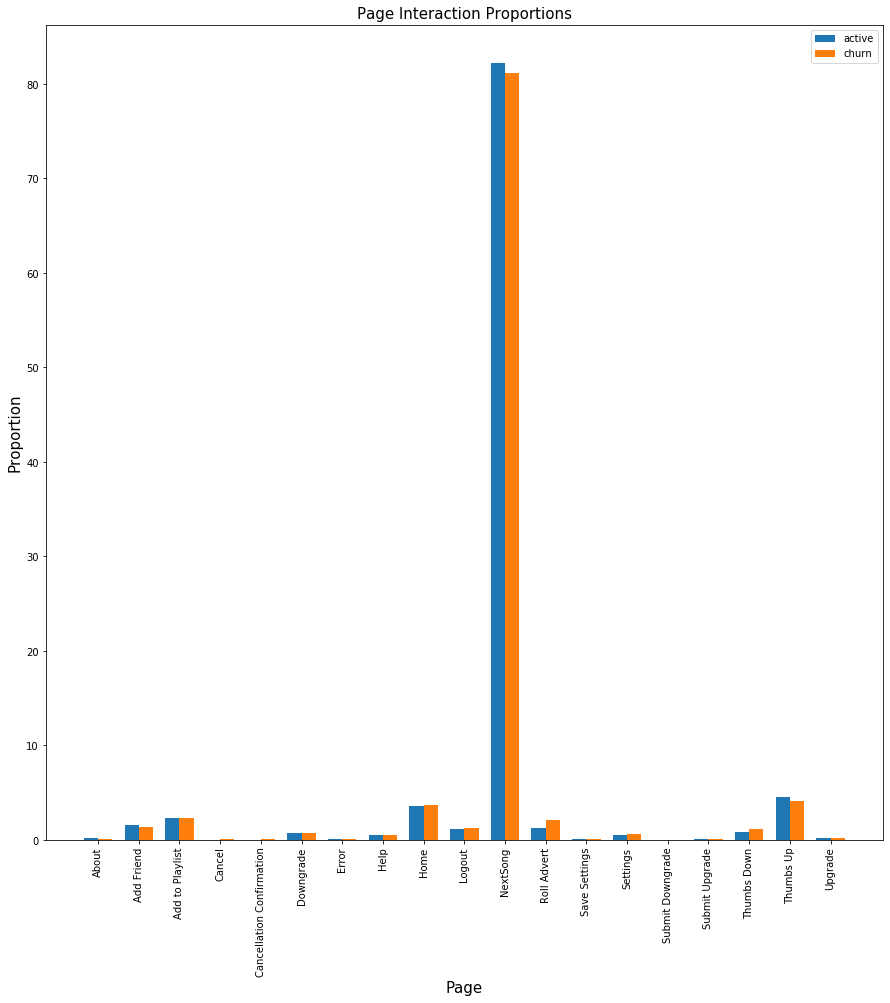

In [58]:
churn_page_inter = spark.sql('''
                             SELECT page, COUNT(users_churn.userId) AS user_inter
                             FROM user_table
                             INNER JOIN users_churn
                             ON user_table.userId = users_churn.userId
                             GROUP BY 1
                             ORDER BY 1 ASC
                             '''
                             ).toPandas()

active_page_inter = spark.sql('''
                              SELECT page, COUNT(users_active.userId) AS user_inter
                              FROM user_table
                              INNER JOIN users_active
                              ON user_table.userId = users_active.userId
                              GROUP BY 1
                              ORDER BY 1 ASC
                              ''').toPandas()

churn_page_inter['user_inter_prop'] = ((churn_page_inter['user_inter'] / churn_page_inter.user_inter.sum())*100)
active_page_inter['user_inter_prop'] = ((active_page_inter['user_inter'] / active_page_inter.user_inter.sum())*100)

page_inter = churn_page_inter.merge(active_page_inter,how='left', left_on='page', right_on='page')
page_inter.fillna(0);

# plotting results
index = np.arange(19)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,15))
active_users_inter = ax.bar(index, page_inter['user_inter_prop_y'], bar_width, label='active')
churn_users_inter = ax.bar(index+bar_width, page_inter['user_inter_prop_x'], bar_width, label='churn')

ax.set_xlabel('Page', fontsize = 15)
ax.set_ylabel('Proportion', fontsize = 15)
ax.set_title('Page Interaction Proportions', size = 15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(page_inter.page, fontsize = 10, rotation=90)
ax.legend(fontsize = 10)
plt.show()

Customers who cancelled had a slightly higher proportion of seeing advertisements, visiting the settings, and giving songs the thumbs down.

Lets see how location affects churn.

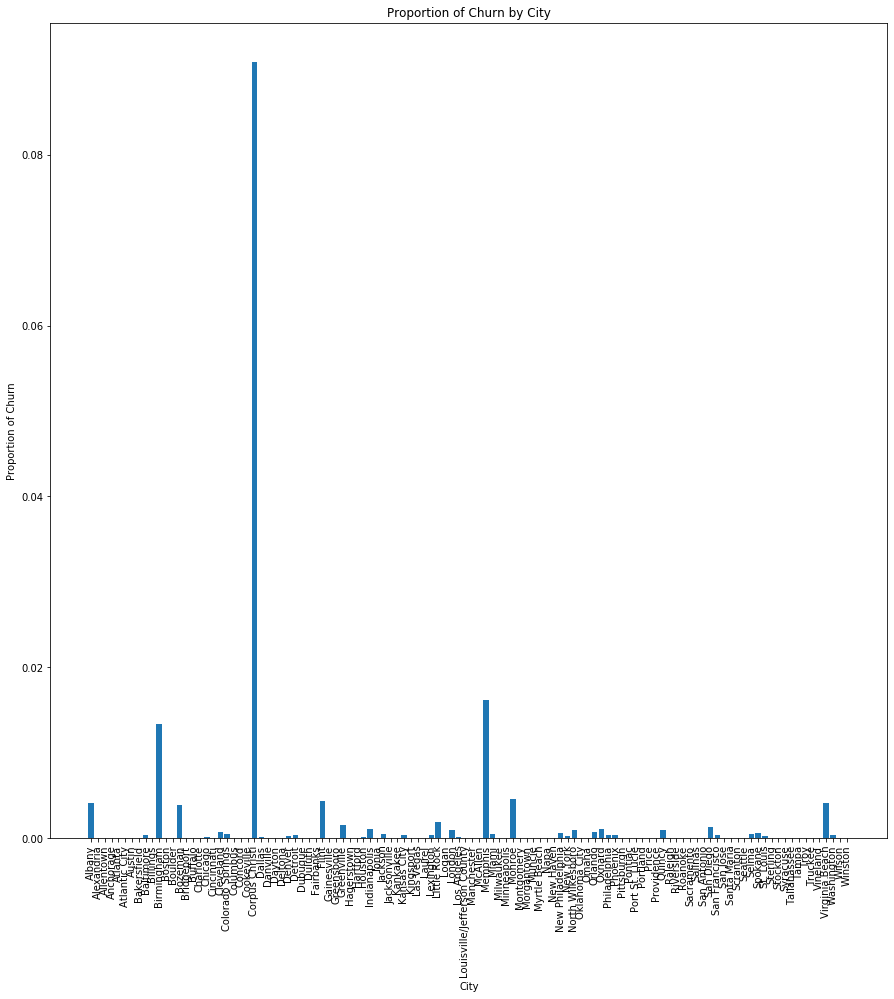

In [59]:
df_city = df.groupby('city','churn').count().sort('city')
df_city_0 = df_city[df_city['churn']==0].toPandas()
df_city_1 = df_city[df_city['churn']==1].toPandas()

df_city.createOrReplaceTempView('temp')

temp_1 = spark.sql('''SELECT COUNT(DISTINCT userId)
                      FROM user_table
                      WHERE churn = 0
                      '''
                      ).toPandas()

temp_2 = spark.sql('''SELECT COUNT(DISTINCT userId)
                      FROM user_table
                      WHERE churn = 1
                      '''
                      ).toPandas()

df_city = df_city_0.merge(df_city_1,how='left', left_on='city', right_on='city')
df_city['churn_y'] = 1
df_city['count_y'] = df_city['count_y'].fillna(0)
df_city['count_y'] = df_city['count_y'].astype('int')
df_city['active'] = df_city.count_x / (df_city.count_x + df_city.count_y)
df_city['churn'] = df_city.count_y / (df_city.count_x + df_city.count_y)

plt.figure(figsize=(15,15))
plt.bar(df_city['city'], df_city['churn'], width = 0.8)
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Proportion of Churn')
plt.title('Proportion of Churn by City');

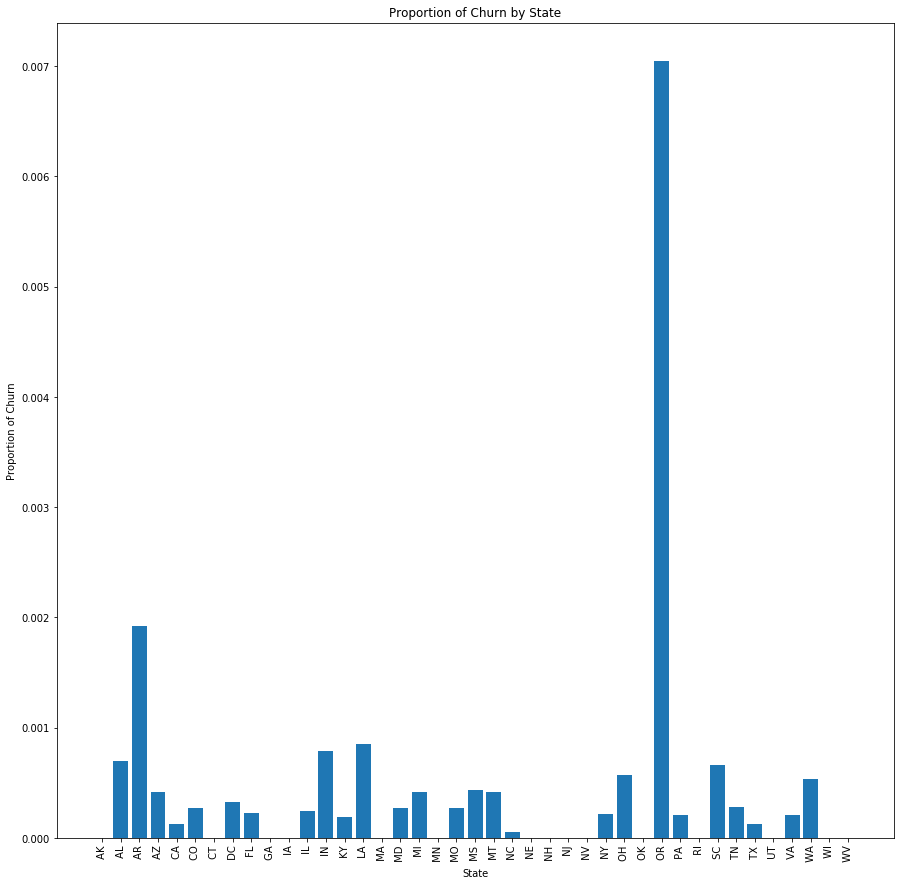

In [60]:
df_state = df.groupby('state','churn').count().sort('state')
df_state_0 = df_state[df_state['churn']==0].toPandas()
df_state_1 = df_state[df_state['churn']==1].toPandas()

df_state.createOrReplaceTempView('temp')

temp_1 = spark.sql('''SELECT COUNT(DISTINCT userId)
                      FROM user_table
                      WHERE churn = 0
                      '''
                      ).toPandas()

temp_2 = spark.sql('''SELECT COUNT(DISTINCT userId)
                      FROM user_table
                      WHERE churn = 1
                      '''
                      ).toPandas()

df_state = df_state_0.merge(df_state_1,how='left', left_on='state', right_on='state')
df_state['churn_y'] = 1
df_state['count_y'] = df_state['count_y'].fillna(0)
df_state['count_y'] = df_state['count_y'].astype('int')
df_state['active'] = df_state.count_x / (df_state.count_x + df_state.count_y)
df_state['churn'] = df_state.count_y / (df_state.count_x + df_state.count_y)

plt.figure(figsize=(15,15))
plt.bar(df_state['state'], df_state['churn'], width = 0.8)
plt.xticks(rotation=90)
plt.xlabel('State')
plt.ylabel('Proportion of Churn')
plt.title('Proportion of Churn by State');

In [61]:
df.toPandas().to_csv('cleaned_data.csv')

# Feature Engineering
Now that we've familiarized ourself with the data, let's build out the features we find promising to train our model on. To work with the full dataset, we can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable
- Try our script on the full data set, debugging our script if necessary

We need to make a dataframe with variables that don't change throughout a users use of sparkify. If we don't spark will give us an error when we try to condense our original data and get multiple values for a column. <br>

For this reason we have to neglect variables we explored like:
> * **location** - state, city

We should focus on the following variables:
> * **userId**
> * **page**
> * **level**
> * **churn**

By using feature engineering we can create even more variables which will be useful for machine learning. Let's give it a try.


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import max as fmax, isnull, avg, udf, split, sum as fsum, countDistinct, col
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LinearSVC, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime
import time

# creating a spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [63]:
def feature_engineering():
    '''
    Returns engineered features for sparkify 
    dataset at a dail value granularity
    
    Input: none
    
    Output: df_users - aggregated daily page count visits
    
    '''

    # loading data
    df = spark.read.json('mini_sparkify_event_data.json')
    # adding parsed dates from 13 digit unix time format
    date = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%d'))
    df = df.withColumn('date', date('ts'))
    
    # creating a user table with which we can join the rest of the engineered features
    df_users = df.where(df.userId != '').select('userId').dropDuplicates()
    # list of page names we want daily values for from the original dataframe df
    page_names = ['Home','Help','Settings','Logout','Downgrade','Submit Downgrade','Roll Advert',
                  'Thumbs Up','Thumbs Down','NextSong','Add to Playlist','Add Friend']
    # new dataframe names to savee the daily values under
    new_page_names = ['Home','Help','Settings','Logout','Downgrade','SubmitDowngrade','Advert',
                      'ThumbsUp','ThumbsDown','NextSong','AddtoPlaylist','AddFriend']
    
    def page_visit_count_daily(page_name):
        '''
        Gets counts by page visited for userId
        
        Input: page_name - page to calculate visit counts for
        
        Output: visit_count - visit counts by userId
        '''
        
        # determining visit count by selecting, grouping and then counting userIds for each day
        visit_count = df.filter(df.page==page_name)\
                        .select('userId','page','date')\
                        .groupby('userId','date')\
                        .agg({'page':'count'})
        
        # returning dataframe of daily counts
        return visit_count

    def average_page_metrics_dv(page_visit_count, new_page_name):
        '''
        Aggregates average of daily value counts
        
        Input: page_visit_count - page visit counts by userId
               new_page_name - the desired pagenew to make a new column with
               
        Output: df_temp - dataframe of userId and daily visits to page
        '''
        
        # taking dail visit counts, grouping by userId and taking the average daily counts
        temp_page_name = 'dv'+new_page_name
        df_temp = page_visit_count.groupBy('userId')\
                                 .mean()\
                                 .withColumnRenamed('avg(count(page))', temp_page_name)
        
        # returning dataframe for daily averages
        return df_temp

    # iterating over the page names
    for i in np.arange(len(page_names)):
        # saving daily average value counts for page names and userIds and joining to users dataframe
        temp_daily = average_page_metrics_dv(page_visit_count_daily(page_names[i]),new_page_names[i])
        df_users = df_users.join(temp_daily, on = 'userId', how = 'leftouter')
        
    # creating dataframe for number of friends
    df_friends = df.select('userId', 'page')\
                   .where(df.page == 'Add Friend')\
                   .groupBy('userId')\
                   .count()\
                   .withColumnRenamed('count', 'Friends')
    # creating dataframe for itemInSession averages
    df_itemInSession = df.select('userId', 'itemInSession')\
                         .groupby('userId')\
                         .mean()\
                         .withColumnRenamed('avg(itemInSession)', 'ItemInSession')
    # creating dataframe for subscription levels 
    sub_level = udf(lambda  x: 1 if x == 'paid' else 0, IntegerType())
    df_paid = df.select('userId', 'level')\
                .where(df.level == 'paid')\
                .dropDuplicates()\
                .withColumn('paid', sub_level('level'))\
                .withColumnRenamed('sum(paid)', 'Paid')\
                .drop('level')
    # creating dataframe for users who've visited submit downgrade
    possChurn = udf(lambda  x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
    df_possChurn = df.withColumn('possChurn', possChurn('page'))\
                     .groupby(['userId'])\
                     .sum()\
                     .withColumnRenamed('sum(possChurn)', 'PossChurn')\
                     .drop('sum(itemInSession)','sum(length)','sum(registration)',
                           'sum(sessionId)','sum(status)','sum(ts)')
    # creating dataframe for users who've cancelled
    churn = udf(lambda  x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
    df_churn = df.withColumn('churn', churn('page'))\
                 .groupby(['userId'])\
                 .sum()\
                 .withColumnRenamed('sum(churn)', 'Churn')\
                 .drop('sum(itemInSession)','sum(length)','sum(registration)',
                       'sum(sessionId)','sum(status)','sum(ts)')
    # joining dataframes to users dataframe
    df_users = df_users.join(df_friends, on = 'userId', how = 'leftouter')
    df_users = df_users.join(df_itemInSession, on = 'userId', how = 'leftouter')
    df_users = df_users.join(df_paid, on = 'userId', how = 'leftouter')
    df_users = df_users.join(df_possChurn, on = 'userId', how = 'leftouter')
    df_users = df_users.join(df_churn, on = 'userId', how = 'leftouter')
    
    
    df_users = df_users.na.fill(0)
    
    return df_users

df = feature_engineering()

In [64]:
#df = spark.read.json('mini_sparkify_event_data.json')
#date = udf(lambda x: datetime.datetime.fromtimestamp(int(x) / 1000.0).strftime('%Y-%m-%d'))
#df = df.withColumn('date', date('ts'))
#regLength = udf(lambda x , y: (x-y).days)
#df_dateReg = df.select('userId','registration','date')\
#               .withColumn('dateReg', date('registration'))\
#               .withColumn('regLength', regLength('dateReg', 'date'))\
#               .drop('dateReg','date')\
#               .groupby('userId')\
#               .mean()
#df_dateReg.show()

In [65]:
def feature_scaling(df):
    '''
    Scaing engineered features using vector assembler
    and minmax scaler
    
    Input: df - dataframe of engineered features
    
    Output: df_scaled - dataframe of scaled engineered features
    '''
    
    # removing columns that shouldn't be scaled
    features = df.drop('userId', 'Churn').columns
    # vectorizing data
    assembler = VectorAssembler(inputCols = features, outputCol = 'feature_vec')
    # creating label column 
    df = df.withColumn('label', df.Churn)
    # scaling dataframe
    scaler = MinMaxScaler(inputCol = 'feature_vec', outputCol = 'features')
    df = assembler.transform(df)
    model = scaler.fit(df)
    df_scaled = model.transform(df)
    
    return df_scaled

df_scaled = feature_scaling(df)

In [66]:
df_scaled.show(3)

+------+------------------+------+----------+------------------+-----------+-----------------+-----------------+------------------+------------+----------+---------------+------------------+-------+-----------------+----+---------+-----+-----+--------------------+--------------------+
|userId|            dvHome|dvHelp|dvSettings|          dvLogout|dvDowngrade|dvSubmitDowngrade|         dvAdvert|        dvThumbsUp|dvThumbsDown|dvNextSong|dvAddtoPlaylist|       dvAddFriend|Friends|    ItemInSession|paid|PossChurn|Churn|label|         feature_vec|            features|
+------+------------------+------+----------+------------------+-----------+-----------------+-----------------+------------------+------------+----------+---------------+------------------+-------+-----------------+----+---------+-----+-----+--------------------+--------------------+
|100010|1.5714285714285714|   1.0|       0.0|               1.0|        0.0|              0.0|7.428571428571429|2.4285714285714284|        1.2

See appendix for exploratory data analysis of engineered features.



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.



In [67]:
rest, train = df_scaled.randomSplit([0.8, 0.2], seed=42)
test, validation = rest.randomSplit([0.5,0.5], seed=42)

In [68]:
def fit_transform(model, train, validation):
    '''
    Trains model and makes predictions
    
    Input: model - classification machine learning algorithm from pyspark.ml.classification
           train - contains training dataframe
           validation - contains validation dataframe
    
    Output: clf - trained machine learning algorithm
            results - predictions on validation data
    
    '''
    clf = model.fit(train)
    results = clf.transform(validation)
    
    return clf, results

In [69]:
def evaluate(results):
    '''
    Evaluates model performance with f1 and accuracy score
    
    Input: results - predictions on validation data
    
    Output: printed performance metrics f1 and accuracy score
    
    '''
    metrics = [ 'f1', 'accuracy']
    
    for metric in metrics:
        evaluator = MulticlassClassificationEvaluator(metricName = metric)
        score = evaluator.evaluate(results.select(col('label'), col('prediction')))
        print(metric,': The score  is {:.2%}'.format(score))
        
    return

In [70]:
models = [RandomForestClassifier(), GBTClassifier(), LinearSVC(),
          LogisticRegression(), DecisionTreeClassifier()]

def model_selection(models):
    '''
    Trains, makes predictions and evaluates a list of machine learning models
    
    Input: models -  a list of classification machine learning algorithms 
                     from pyspark.ml.classification
    
    Output: printed performance metrics f1, accuracy score, and training time
    
    '''

    for m in models:
        start_time = time.time()
        model = m
        print('Training Model...',m)
        clf, results = fit_transform(model, train, validation)
        print('Evaluating Model...')
        evaluate(results)
        current_time = time.time()
        elapsed_time = current_time - start_time
        print('Time:',elapsed_time/60,'minutes \n')
        
    return

model_selection(models) 

Training Model... RandomForestClassifier_24363cb7d6f7
Evaluating Model...
f1 : The score  is 67.50%
accuracy : The score  is 69.01%
Time: 6.731365919113159 minutes 

Training Model... GBTClassifier_fc51ac96b49c
Evaluating Model...
f1 : The score  is 65.05%
accuracy : The score  is 63.38%
Time: 7.697913730144501 minutes 

Training Model... LinearSVC_f0c3603b834b
Evaluating Model...
f1 : The score  is 65.40%
accuracy : The score  is 63.38%
Time: 13.346189693609874 minutes 

Training Model... LogisticRegression_056df3df934a
Evaluating Model...
f1 : The score  is 67.33%
accuracy : The score  is 66.20%
Time: 7.613424750169118 minutes 

Training Model... DecisionTreeClassifier_acc96524e30e
Evaluating Model...
f1 : The score  is 62.97%
accuracy : The score  is 61.97%
Time: 6.636902598539988 minutes 



The logistic regression classifier had the best combination of training time and f1 score. We can choose this algorithm and grid search our parameters with cross validation them on our f1 metric.

In [71]:
model = RandomForestClassifier()

param_grid = ParamGridBuilder().addGrid(model.numTrees, [5,10,50])\
                               .addGrid(model.maxDepth, [3,4,5])\
                               .build()

    
crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=param_grid,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

model_cv = crossval
clf = model_cv.fit(train)
results = clf.transform(validation)
evaluate(results)

f1 : The score  is 67.16%
accuracy : The score  is 71.83%


The grid search did produce a more promising model. So we will keep the model and evaluate it against the testing set.

In [72]:
clf.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_60d039bf31af', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): True,
 Param(parent='RandomForestClassifier_60d039bf31af', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='RandomForestClassifier_60d039bf31af', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='RandomForestClassifier_60d039bf31af', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supp

In [73]:
model = RandomForestClassifier(numTrees=10, maxDepth=3)
clf = model.fit(train)
results = clf.transform(test)
evaluate(results)

f1 : The score  is 72.22%
accuracy : The score  is 75.21%


In [74]:
results.select('features', 'rawPrediction', 'probability',
               'prediction', 'label', 'userId').show()

+--------------------+--------------------+--------------------+----------+-----+------+
|            features|       rawPrediction|         probability|prediction|label|userId|
+--------------------+--------------------+--------------------+----------+-----+------+
|[0.89285714285714...|[4.83420335286902...|[0.48342033528690...|       1.0|    1|    51|
|[0.88571428571428...|[5.77420335286902...|[0.57742033528690...|       0.0|    0|    15|
|[0.61428571428571...|[8.66820079859060...|[0.86682007985906...|       0.0|    1|    54|
|[0.33333333333333...|[8.27463783981025...|[0.82746378398102...|       0.0|    1|100014|
|[0.79047619047619...|[4.83420335286902...|[0.48342033528690...|       1.0|    0|   132|
|[0.62857142857142...|[8.50910988949969...|[0.85091098894996...|       0.0|    0|    42|
|[0.42857142857142...|[8.19907991946972...|[0.81990799194697...|       0.0|    1|    73|
|[0.33333333333333...|[9.18768131807112...|[0.91876813180711...|       0.0|    0|200010|
|[0.33333333333333...

In [75]:
df_scaled.show()

+------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+------------------+----+---------+-----+-----+--------------------+--------------------+
|userId|            dvHome|            dvHelp|        dvSettings|          dvLogout|       dvDowngrade|dvSubmitDowngrade|          dvAdvert|        dvThumbsUp|      dvThumbsDown|        dvNextSong|   dvAddtoPlaylist|       dvAddFriend|Friends|     ItemInSession|paid|PossChurn|Churn|label|         feature_vec|            features|
+------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+------------------+----+---------+-----+-----+--------------------+--------------------+
|100

Our algorithm seems to have done a great job identifying 86.1% of users who are going to churn. The evaluation with which we chose the logistic regression classifier is based on f1 score:<br>

$F1 = \frac{2*Precision*Recall}{Precision+Recall}$<br>

We also tested it against the validation and testing data set with an f1 and accuracy score of approximately 86-88%. All of the models we tested had an f1 and accuracy score less than that. I'm sure we could have gridsearched and crossvalidated our parameters to make the model preform better. However, the clssififer provided the best predictions and trained the fastest.

This is important because we are planning to scale our analysis to a 12 GB dataset on AWS on a distributed computing spark cluster framework. The longer our algorithm takes to train, the more money we spend and therefore the less economical our choice becomes.

# Discussion

Our analysis had three main steps:

>1. Exploratory Data Analysis <br>
>2. Feature Engineering <br>
>3. Modelling <br>

Each presented its own challenges. <br>

Spark has many different ways you can query. There is imperative and declaritive programming. I tried used both to become more fluent in the options available to me. <br>

**Here is an example of imperative programming**:<br>
```python
churn = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_test = df.withColumn('churn', churn('page'))
userwindow = Window.partitionBy('userId')
                   .rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_test = df_test.withColumn('churn', fmax('churn').over(userwindow))
df_test.select(['churn', 'page']).groupby(['churn', 'page']).count().sort('page').show()
```

**Here is an example of declaritive programming**:<br>
```python
temp = spark.sql('''
                 SELECT DISTINCT userId
                 FROM user_table
                 WHERE churn = 0
                 ORDER BY 1 ASC
                 '''
                 )

temp.createOrReplaceTempView('temp')

users_churn = spark.sql('''
                        SELECT DISTINCT userId
                        FROM user_table
                        WHERE churn = 1
                        ORDER BY 1 ASC
                        '''
                        )

users_churn.createOrReplaceTempView('users_churn')

users_active = spark.sql('''
                         SELECT t.userId
                         FROM temp AS t
                         LEFT JOIN users_churn AS u
                         ON t.userId = u.userId
                         WHERE u.userId IS NULL
                         ORDER BY 1 ASC
                         ''')

users_active.createOrReplaceTempView('users_active')

churn_page_inter = spark.sql('''
                             SELECT page, COUNT(users_churn.userId) AS user_inter
                             FROM user_table
                             INNER JOIN users_churn
                             ON user_table.userId = users_churn.userId
                             GROUP BY 1
                             ORDER BY 1 ASC
                             '''
                             ).toPandas()

active_page_inter = spark.sql('''
                              SELECT page, COUNT(users_active.userId) AS user_inter
                              FROM user_table
                              INNER JOIN users_active
                              ON user_table.userId = users_active.userId
                              GROUP BY 1
                              ORDER BY 1 ASC
                              ''').toPandas()
churn_page_inter.merge(active_page_inter, on='page', suffixes = ('_1','_0'))
```

Amazingly both produce the same information, one is much faster and easier to program. This made the exploratory data analysis a challenge with some many options to query data. I eventually figured the best pratices and used it in my feature engineering <br>

Feature engineering had its difficulties as well. Choosing which pieces of the original data we wanted to keep and transform to the variables we would use for modelling took alot of trial and error. What you see in the feature engineering section is my final polished work. I challeneged myself to refrain from using SQL or declaritive programming, which I'm more comfortable with, and used imperative programming to make it more concise and clean. <br>

I could further improve the exploratory data analysis section which could be made more concise by the use of imperative programming instead of declarative. Furthermore, I wish I choose more parameters to hyper tune. Afterall, the more accurate the model the more users we can retain.

# Conclusion

The goal of this project is to take a dataset, perform feature engineering, scale the features and preform some modelling so that we can make accurate predictions on whether a customer will churn or not.

This was accomplished through imperative feature engineering of the userId, page, level, and churn columns. Minmax feature scaling was applied to all engineered features. During modelling a random forest classifier was used. I was able to make a model with an f1 and accuracy score of 86-88%% on testing and validation datasets.

### Appendix
Proof of concept exploratory data analysis for engineered features

In [76]:
df.select(['dvThumbsDown','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid| avg(dvThumbsDown)|
+-----+----+------------------+
|    1|   1|1.8653549382716053|
|    0|   0|0.8988636363636363|
|    0|   1|1.6918595557966987|
|    1|   0|1.0461309523809523|
+-----+----+------------------+



In [77]:
df.select(['dvThumbsUp','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid|   avg(dvThumbsUp)|
+-----+----+------------------+
|    1|   1|4.6142464848755695|
|    0|   0|2.4410296143250685|
|    0|   1|5.0761605064919815|
|    1|   0| 2.435416666666667|
+-----+----+------------------+



In [78]:
df.select(['dvHelp','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid|       avg(dvHelp)|
+-----+----+------------------+
|    1|   1|1.2990139490139487|
|    0|   0|0.6666666666666666|
|    0|   1|1.4565523905845386|
|    1|   0|           0.59375|
+-----+----+------------------+



In [79]:
df.select(['dvAdvert','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid|     avg(dvAdvert)|
+-----+----+------------------+
|    1|   1|3.2021885521885527|
|    0|   0|  3.28459595959596|
|    0|   1|2.6283376952542596|
|    1|   0|4.8318948412698415|
+-----+----+------------------+



In [80]:
df.select(['dvLogout','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid|     avg(dvLogout)|
+-----+----+------------------+
|    1|   1|1.9720807254798478|
|    0|   0| 1.178030303030303|
|    0|   1| 1.823409635567844|
|    1|   0| 1.099337121212121|
+-----+----+------------------+



In [81]:
df.select(['Friends','Paid','Churn'])\
  .groupby(['Churn','Paid']).mean()\
  .drop('avg(Churn)','avg(Paid)').show()

+-----+----+------------------+
|Churn|Paid|      avg(Friends)|
+-----+----+------------------+
|    1|   1| 16.22222222222222|
|    0|   0|3.6363636363636362|
|    0|   1|26.984496124031008|
|    1|   0|              3.25|
+-----+----+------------------+



### Saving Data for Web App

In [82]:
df.toPandas().to_csv('feat_eng_data.csv')
results.toPandas().to_csv('results_data.csv')

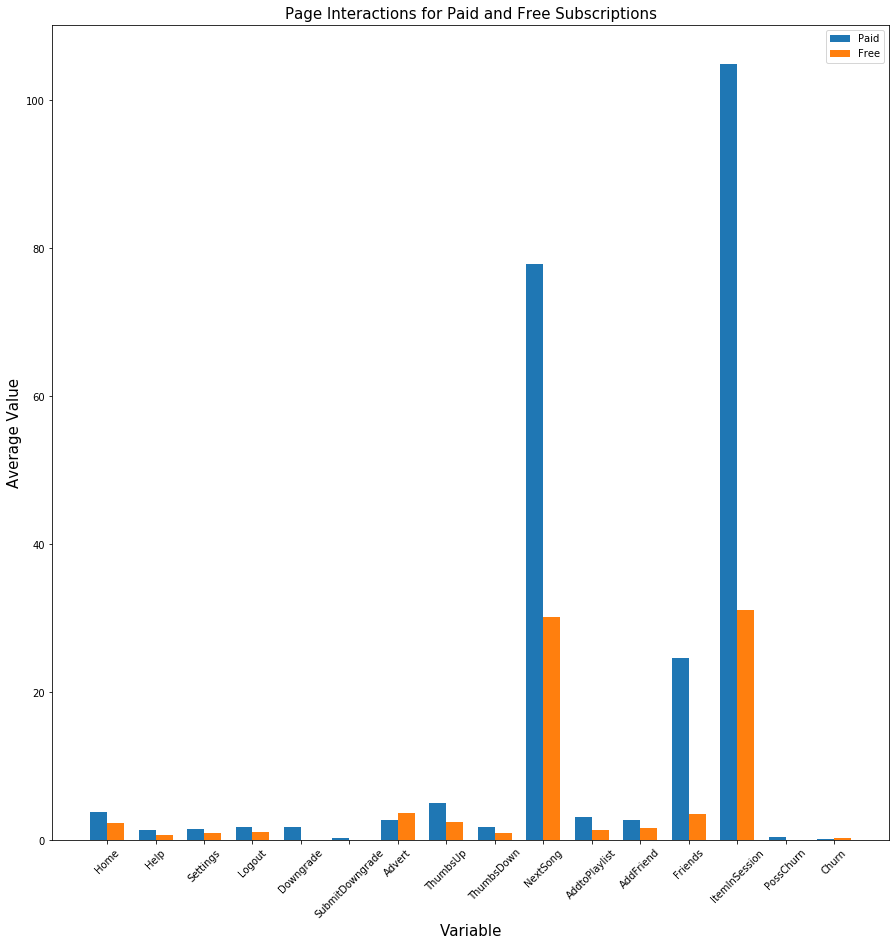

In [83]:
plot_1 = df.groupby(['Paid']).mean()\
           .drop('avg(Paid)')\
           .withColumnRenamed('avg(dvHome)', 'Home')\
           .withColumnRenamed('avg(dvHelp)', 'Help')\
           .withColumnRenamed('avg(dvSettings)', 'Settings')\
           .withColumnRenamed('avg(dvLogout)', 'Logout')\
           .withColumnRenamed('avg(dvDowngrade)', 'Downgrade')\
           .withColumnRenamed('avg(dvSubmitDowngrade)', 'SubmitDowngrade')\
           .withColumnRenamed('avg(dvAdvert)', 'Advert')\
           .withColumnRenamed('avg(dvThumbsUp)', 'ThumbsUp')\
           .withColumnRenamed('avg(dvThumbsDown)', 'ThumbsDown')\
           .withColumnRenamed('avg(dvNextSong)', 'NextSong')\
           .withColumnRenamed('avg(dvAddtoPlaylist)', 'AddtoPlaylist')\
           .withColumnRenamed('avg(dvAddFriend)', 'AddFriend')\
           .withColumnRenamed('avg(Friends)', 'Friends')\
           .withColumnRenamed('avg(ItemInSession)', 'ItemInSession')\
           .withColumnRenamed('avg(PossChurn)', 'PossChurn')\
           .withColumnRenamed('avg(Churn)', 'Churn')\
           .toPandas()

plot_1 = pd.melt(plot_1, id_vars=['Paid'])
plot_1.to_csv('plot_1_data.csv')

index = np.arange(plot_1.shape[0] / 2)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,15))
ax.bar(index, plot_1[plot_1['Paid'] ==1].value, bar_width, label='Paid')
ax.bar(index+bar_width, plot_1[plot_1['Paid'] ==0].value, bar_width, label='Free')

ax.set_xlabel('Variable', fontsize = 15)
ax.set_ylabel('Average Value', fontsize = 15)
ax.set_title('Page Interactions for Paid and Free Subscriptions', size = 15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(plot_1[plot_1['Paid'] ==1].variable, fontsize = 10, rotation=45)
ax.legend(fontsize = 10)
plt.show()

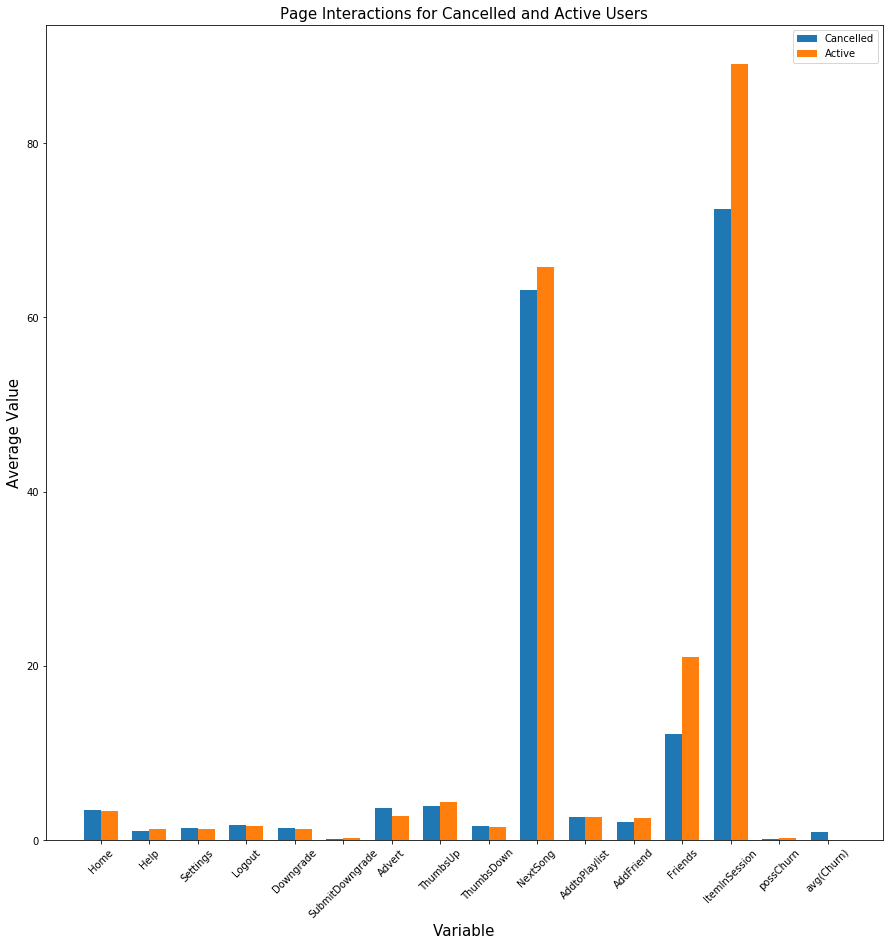

In [84]:
plot_2 = df.groupby(['Churn']).mean()\
           .drop('avg(Paid)')\
           .withColumnRenamed('avg(dvHome)', 'Home')\
           .withColumnRenamed('avg(dvHelp)', 'Help')\
           .withColumnRenamed('avg(dvSettings)', 'Settings')\
           .withColumnRenamed('avg(dvLogout)', 'Logout')\
           .withColumnRenamed('avg(dvDowngrade)', 'Downgrade')\
           .withColumnRenamed('avg(dvSubmitDowngrade)', 'SubmitDowngrade')\
           .withColumnRenamed('avg(dvAdvert)', 'Advert')\
           .withColumnRenamed('avg(dvThumbsUp)', 'ThumbsUp')\
           .withColumnRenamed('avg(dvThumbsDown)', 'ThumbsDown')\
           .withColumnRenamed('avg(dvNextSong)', 'NextSong')\
           .withColumnRenamed('avg(dvAddtoPlaylist)', 'AddtoPlaylist')\
           .withColumnRenamed('avg(dvAddFriend)', 'AddFriend')\
           .withColumnRenamed('avg(Friends)', 'Friends')\
           .withColumnRenamed('avg(ItemInSession)', 'ItemInSession')\
           .withColumnRenamed('avg(PossChurn)', 'possChurn')\
           .withColumnRenamed('avg(Paid)', 'Paid')\
           .toPandas()

plot_2 = pd.melt(plot_2, id_vars=['Churn'])
plot_2.to_csv('plot_2_data.csv')

index = np.arange(plot_1.shape[0] / 2)
bar_width = 0.35

fig, ax = plt.subplots(figsize=(15,15))
ax.bar(index, plot_2[plot_2['Churn'] ==1].value, bar_width, label='Cancelled')
ax.bar(index+bar_width, plot_2[plot_2['Churn'] ==0].value, bar_width, label='Active')

ax.set_xlabel('Variable', fontsize = 15)
ax.set_ylabel('Average Value', fontsize = 15)
ax.set_title('Page Interactions for Cancelled and Active Users', size = 15)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(plot_2[plot_2['Churn'] ==1].variable, fontsize = 10, rotation=45)
ax.legend(fontsize = 10)
plt.show()